In [1]:
%matplotlib inline

In [2]:
import argparse
import collections
import sqlite3
import sys

import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from importlib import reload
import parse_db
reload(parse_db)

<module 'parse_db' from '/Users/jobevers/projects/personal/bowlingscorer/parse_db.py'>

In [4]:
conn = sqlite3.connect('/Users/jobevers/Dropbox/bowling/Backup.db')
conn.row_factory = sqlite3.Row 

In [5]:
parse_db.process_db(conn)

First Ball Average: 8.476666666666667
You've bowled 300 frames
---
Pin Leaves
Pin	1	2
1	14.67%	3.00%
2	13.33%	4.33%
3	20.00%	6.00%
4	16.00%	5.33%
5	14.33%	2.67%
6	20.67%	5.67%
7	15.00%	6.67%
8	5.67%	2.00%
9	11.33%	2.33%
10	21.33%	10.00%
---
Strikes: 86 / 300 => 28.666667%
Spares: 113 / 300 => 37.666667%
Opens: 101 / 300 => 33.666667%
---
Splits: 46 / 214 => 21.495327%
Split-Conversion: 7 / 46 => 15.217391%
---
Non-Splits: 168 / 214 => 78.504673%
Non-Split-Conversion: 106 / 168 => 63.095238%
---
Single Pin Leaves: 80 / 168 => 0.47619047619047616
Single Pin Conversion: 53 / 80 =>  0.6625
For pin 10: 10 / 17 => 58.8%
For pin 7: 4 / 9 => 44.4%
For pin 6: 12 / 17 => 70.6%
For pin 3: 7 / 10 => 70.0%
For pin 2: 0 / 3 => 0.0%
For pin 4: 6 / 8 => 75.0%
For pin 9: 5 / 6 => 83.3%
For pin 8: 1 / 2 => 50.0%
For pin 5: 7 / 7 => 100.0%
For pin 1: 1 / 1 => 100.0%
SINGLE PIN CONVERSION IS THE EASIEST WAY TO IMPROVE YOUR AVERAGE!
IF THIS WAS 100%, YOUR AVERAGE WOULD INCREASE BY: 8.529


In [6]:
# ['ID', 'Game', 'Frame', 'T1', 'T2', 'Foul1', 'Foul2', 'Split', 'Renzoku', 'Pin']
rows = conn.execute('select * from T_Games where Frame <= 10').fetchall()
df = pd.DataFrame(rows, columns=rows[0].keys())
fba = df['T1'].mean()
print(f'First Ball Average: {fba}')

pin_leaves = []
for row in rows:
    pins = row['Pin']
    pin_leaves.append(parse_db.parse_pins(pins))
n = len(pin_leaves)

First Ball Average: 8.476666666666667


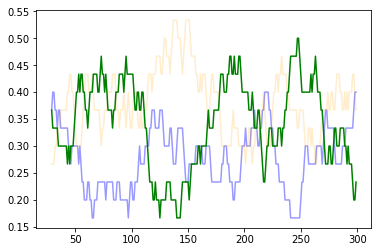

In [84]:
is_strike = (df['T1'] == 10).astype(int)
rolling_strike = is_strike.rolling(30).mean()
is_open = (df['T1'] + df['T2'] < 10).astype(int)
rolling_open = is_open.rolling(30).mean()
rolling_spare = 1 - rolling_strike - rolling_open
rolling_strike.plot(color="blue", alpha=.4)
rolling_spare.plot(color="orange", alpha=.2)
rolling_open.plot(color="green");
# blue => strike
# orange => spare
# green => open

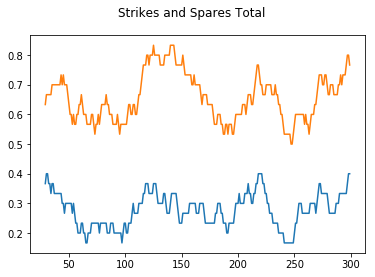

In [85]:
ax = pd.DataFrame({'Strike': rolling_strike, 'Spare': spare}).dropna().plot(
    stacked=True, legend=False)
ax.figure.suptitle('Strikes and Spares Total');

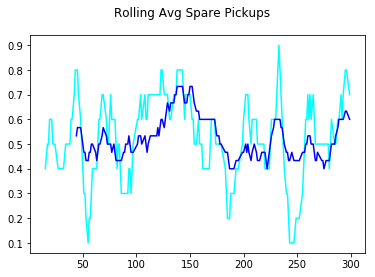

In [77]:
spare_leaves = df[df['T1'] < 10]
spare_pickups = (spare_leaves['T1'] + spare_leaves['T2'] == 10).astype(int)
ax = spare_pickups.rolling(10).mean().plot(color="cyan");
spare_pickups.rolling(30).mean().plot(color="blue")
ax.figure.suptitle('Rolling Avg Spare Pickups');

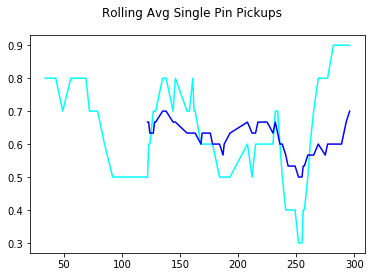

In [78]:
single_pin_leaves = df[df['T1'] == 9]
single_pin_spares = (single_pin_leaves['T2'] == 1).astype(int)
ax = single_pin_spares.rolling(10).mean().plot(color="cyan");
single_pin_spares.rolling(30).mean().plot(color="blue")
ax.figure.suptitle('Rolling Avg Single Pin Pickups');

In [8]:
# ['ID', 'Game', 'Frame', 'T1', 'T2', 'Foul1', 'Foul2', 'Split', 'Renzoku', 'Pin']
rows = conn.execute('select * from T_Score').fetchall()
totals = pd.DataFrame(rows, columns=rows[0].keys())

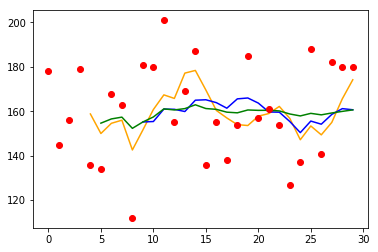

In [9]:
fig, ax = plt.subplots()
scores = totals['Score']
scores.rolling(5).mean().plot(ax=ax, label='5gm Avg', color="orange")
scores.rolling(10).mean().plot(ax=ax, label='10gm Avg', color="blue")
scores.expanding(6).mean().plot(ax=ax, label='League Avg', color="green")
scores.plot(ax=ax, marker='o', linestyle='', color="red");
#ax.legend()

In [10]:
def get_single_pin_leaves(pin_leaves, pin):
    for i, leave in enumerate(pin_leaves):
        if leave['first_ball'] == {pin}:
            yield i, leave

def get_makes(pin_leaves, pin):
    for i, leave in get_single_pin_leaves(pin_leaves, pin):
        if len(leave['second_ball']) == 0:
            yield i
            
def get_misses(pin_leaves, pin):
    for i, leave in get_single_pin_leaves(pin_leaves, pin):
        if len(leave['second_ball']) == 1:
            yield i

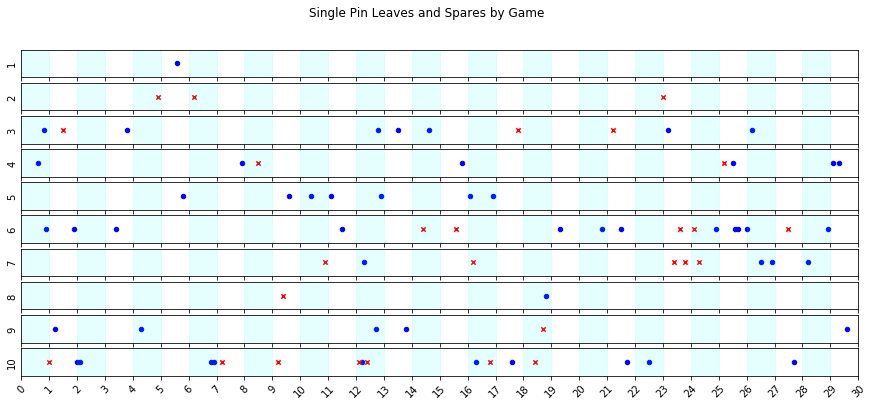

In [86]:
x = range(len(pin_leaves))
fig, axs = plt.subplots(nrows=10, ncols=1, sharex=True, figsize=(15, 6))
for pin, ax in enumerate(axs, 1):
    makes = list(get_makes(pin_leaves, pin))
    ax.scatter(makes, [0]*len(makes), marker='o', color='b', s=20)
    misses = list(get_misses(pin_leaves, pin))
    ax.scatter(misses, [0]*len(misses), marker='x', color='r', s=20)
    ax.set_yticks([])
    ax.set_ylabel(pin)
    ax.set_xlim(0, len(pin_leaves))
    for i in range(0, len(pin_leaves), 20):
        ax.axvspan(i, i+10, color='cyan', alpha=.1)
ax.set_xticks(range(0, len(pin_leaves)+10, 10))
ax.set_xticklabels(range(0, int(len(pin_leaves)/10)+1));
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
fig.suptitle('Single Pin Leaves and Spares by Game');